<a id="top"></a>

# Jupyter Notebooks for SOEP data analysis
## Python Notebook
In this Jupyter Notebook an exemplary analysis of SOEP data is conducted with Python 3.7.3 and common data science libraries.

---

**Authors:**

Heinz-Alexander Fütterer (ZBW) and [Andreas Franken (DIW)](https://www.diw.de/de/diw_01.c.556354.de/ueber_uns/menschen_am_diw_berlin/franken_andreas.html)

---

## Index

* [Introduction](#introduction)
* [Goal](#goal)
* [Set up environment](#environment)
* [Dataset: `ppathl.dta` (Individual Tracking File)](#dataset-ppathl)
* [Dataset: `pgen.dta` (Generated Individual Data)](#dataset-pgen)
* [Dataset: `hgen.dta` (Generated Household Data)](#dataset-hgen)
* [Version and Hardware Information](#version-hardware-info)

<a id="introduction"></a>
[Return to top](#top)
## Introduction
The datasets we use in this notebook are part of the bilingual Stata based distribution of the SOEP data in version 34.
Researchers will find the datasets in `STATA_DEEN_v34.zip`. We assume the datasets to be extracted to a directory called `data/`.

Citation:
> Liebig, Stefan; Schupp, Jürgen; Goebel, Jan; Richter, David; Schröder, Carsten et. al. (2019): Sozio-oekonomisches Panel (SOEP), Daten der Jahre 1984-2017. Version: v34. SOEP - Sozio-oekonomisches Panel. Dataset. http://doi.org/10.5684/soep.v34

We will make use of three datasets: `hgen.dta`, `pgen.dta` and `ppathl.dta`.

See also:
- <https://www.diw.de/sixcms/detail.php?id=diw_01.c.616136.de>
- <https://paneldata.org/soep-core>
- <https://paneldata.org/soep-core/data/hgen>
- <https://paneldata.org/soep-core/data/pgen>
- <https://paneldata.org/soep-core/data/ppathl>
- <http://companion.soep.de/>
- <https://www.da-ra.de/dara/search/search_show?res_id=672526&lang=en&mdlang=de&detail=true>

<a id="goal"></a>
[Return to top](#top)
## Goal
This notebook demonstrates how to:
-   read (multiple) SOEP data from Stata files on disk
-   load external / install external libraries for data analysis
-   preprocess data, e.g.
    -   drop rows based on certain conditions
    -   declare values as NaN
    -   merge tables based on shared columns as keys
-   generate descriptive statistics of (multiple) columns of a table
-   generate crosstables
-   generate histograms
-   generate box plots
-   calculate correlations betweeen columns
-   generate new columns based on existing columns
-   calculate a statistical model, e.g. linear regression

[Return to top](#top)
<a id="environment"></a>
## Set up environment
We import the libraries for the coming data analysis steps.

In [1]:
from pathlib import Path
from linearmodels import PooledOLS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib notebook

We set the base directory to read Stata files from. This directory is assumed to be the extracted version of `STATA_DEEN_v34.zip`. For demonstration purposes it contains only the three datasets we are interested in for this notebook. We can verify the integrity of the files with `md5sum`:

In [2]:
DATASETS_DIRECTORY = Path('data/')
! md5sum $DATASETS_DIRECTORY/*

510427c28ed0d7113d989a3651191af2  data/hgen.dta
096d87642640a076f4514b7163e716b2  data/pgen.dta
33fef93b16c406d2a82350772d6070cc  data/ppathl.dta


We begin to read Stata files from disk.

<a id="dataset-ppathl"></a>
[Return to top](#top)
## Dataset: `ppathl.dta` (Individual Tracking File)
From <https://paneldata.org/soep-core/data/ppathl>:

> Person core information and respondent status for each year in long format. It contains one record for each individual and year a person has been a member of a respondent household. It is keyed on PID, the Cross-Wave Person Identifier, and SYEAR, the survey year identifier. It contains the Household ID, and never changing individual characteristics, individual weights, as well as the response status, for that individual at each wave, see http://www.diw.de/documents/dokumentenarchiv/17/diw_01.c.432038.de/diw_ssp0150_ppfad.pdf.

In [3]:
! ls -lh $DATASETS_DIRECTORY/ppathl.dta

-rwxr-xr-x 1 afuetterer afuetterer 123M Mär  6 12:42 data/ppathl.dta


The file `ppathl.dta` has a size of 123 MB and contains 1039257 rows with 48 columns, e.g. 1039257 observations with 48 variables.

In [4]:
filename = DATASETS_DIRECTORY / "ppathl.dta"
ppathl = pd.read_stata(filename, convert_categoricals=False)
ppathl.shape

(1039257, 48)

In [5]:
ppathl.columns

Index(['pid', 'syear', 'cid', 'sex', 'gebjahr', 'eintritt', 'erstbefr',
       'austritt', 'psample', 'letztbef', 'hid', 'sampreg', 'netto', 'nett1',
       'casemat', 'pop', 'todjahr', 'todinfo', 'immiyear', 'germborn',
       'corigin', 'gebmonat', 'gebmoval', 'loc1989', 'migback', 'miginfo',
       'germborninfo', 'corigininfo', 'immiyearinfo', 'sexor', 'sexorinfo',
       'locinfo', 'birthregion', 'arefback', 'arefinfo', 'prgroup', 'pbleib',
       'phrf', 'phrf0', 'phrf1', 'phrfe', 'pbleibe', 'phrfe0', 'phrfe1',
       'persnr', 'parid', 'partner', 'piyear'],
      dtype='object')

<a id="variable-netto"></a>
### Variable: `netto` (Current survey status)

Value labels we are interested in:

- [10] Interviewee With Succesful Interview (_P)
- [12] Individual Questionnaire And Person Biography
- [13] Individual Questionnaire And Youth Biography
- [14] Individual Questionnaire And Other Questionnaires
- [15] Individual Questionnaire And Experiments, Test
- [16] Individual Questionnaire, First Time Surveyed, Age 17
- [17] Youth Biography First Time Surveyed, Age 17
- [18] Individual Questionnaire And Child under age 17
- [19] Individual Questionnaire Without Household Interview

see: <https://paneldata.org/soep-core/data/ppathl/netto>

In [6]:
# select a subset of rows by a condition on one column
# only keep rows describing "adults with 'realized' interviews"
ppathl = ppathl[ppathl["netto"].between(1, 19)]
ppathl.shape

(657601, 48)

<a id="variable-pop"></a>
### Variable: `pop` (Sample Membership)

Value labels we are interested in:

- [1] Private HH, German HH-Head
- [2] Private HH, Foreign HH-Head
- [3] Institutional. HH, Collective accommodation, German HH-Head	
- [4] Institutional. HH, Collective accommodation, Foreign HH-Head

see: <https://paneldata.org/soep-core/data/ppathl/pop>

In [7]:
# select a subset of rows by a condition on one column
ppathl = ppathl.loc[(ppathl['pop'] > 0) & (ppathl['pop'] < 5)]
ppathl.shape

(656960, 48)

<a id="hist-syear"></a>
### Histogram: Survey Year

Generate a histogram of the variable `syear` (Survey Year). The histogram shows the number of participants in the survey per year.


see: <https://paneldata.org/soep-core/data/ppathl/syear>

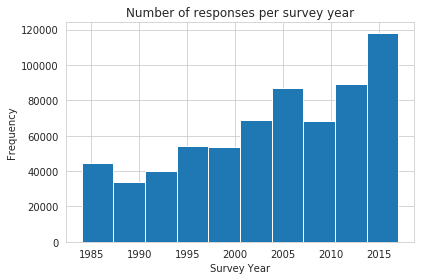

In [8]:
ppathl.hist("syear")
plt.title("Number of responses per survey year")
plt.xlabel("Survey Year")
plt.ylabel("Frequency")
plt.tight_layout()

<a id="crosstab-syear-sex"></a>
### Crosstable between two columns: Survey year and gender

The crosstable shows the gender distribution of the participants in the survey per year.

Variables used:
- `syear` (Survey Year), see: <https://paneldata.org/soep-core/data/ppathl/syear>
- `sex` (Gender), see: <https://paneldata.org/soep-core/data/ppathl/sex> 

In [9]:
crosstab = pd.crosstab(ppathl["syear"], ppathl["sex"])
crosstab.rename(columns={1: "male", 2: "female"}, inplace=True)
crosstab

sex,male,female
syear,,
1984,6007,6238
1985,5458,5632
1986,5267,5379
1987,5208,5308
1988,4955,5068
1989,4781,4929
1990,6806,7166
1991,6663,7006
1992,6494,6903


<a id="crosstab-syear-psample"></a>
### Crosstable between two columns: Survey year and Sample Member

The crosstable shows the Sample member distribution of the participants in the survey per year.

Variables used:
- `syear` (Survey Year), see: <https://paneldata.org/soep-core/data/ppathl/syear>
- `psample` (Sample Member), see: <https://paneldata.org/soep-core/data/ppathl/psample>

In [10]:
crosstab = pd.crosstab(ppathl["syear"], ppathl["psample"], margins=True)
crosstab

psample,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,All
syear,,,,,,,,,,,,,,,,,,,,,
1984,9076,3169,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12245
1985,8372,2718,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11090
1986,8009,2637,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10646
1987,7868,2648,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10516
1988,7481,2542,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10023
1989,7201,2509,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9710
1990,7036,2483,4453,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13972
1991,6974,2493,4202,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13669
1992,6821,2484,4092,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13397


<a id="dataset-pgen"></a>
[Return to top](#top)
## Dataset: `pgen.dta` (Generated Individual Data)

From <https://paneldata.org/soep-core/data/pgen>:

> Contains individual-level generated data to ensure complete and consitent information over time. It is keyed on PID (Person ID) and SYEAR (Survey Year), see http://www.diw.de/documents/dokumentenarchiv/17/diw_01.c.432040.de/diw_ssp0149_pgen.pdf.

In [11]:
! ls -lh $DATASETS_DIRECTORY/pgen.dta

-rwxr-xr-x 1 afuetterer afuetterer 133M Mär  6 12:37 data/pgen.dta


In [12]:
filename = DATASETS_DIRECTORY / "pgen.dta"
pgen = pd.read_stata(filename, convert_categoricals=False)
pgen.shape

(657963, 84)

In [13]:
pgen.columns

Index(['pid', 'hid', 'cid', 'sample1', 'syear', 'pgnation', 'pgstatus_asyl',
       'pgstatus_refu', 'pgpartz', 'pgpartnr', 'pgfamstd', 'pglabgro',
       'pgimpgro', 'pglabnet', 'pgimpnet', 'pgsndjob', 'pgimpsnd', 'pgstib',
       'pgemplst', 'pglfs', 'pgjobch', 'pgisco88', 'pgisco08', 'pgisei88',
       'pgkldb92', 'pgkldb2010', 'pgmps92', 'pgsiops88', 'pgegp88', 'pgerljob',
       'pgausb', 'pgerwzeit', 'pgtatzeit', 'pgvebzeit', 'pguebstd', 'pgoeffd',
       'pgnace', 'pgnace2', 'pgbetr', 'pgallbet', 'pgjobend', 'pgexpft',
       'pgexppt', 'pgexpue', 'pgisced97', 'pgisced11', 'pgcasmin', 'pgbilzeit',
       'pgpsbil', 'pgpbbil01', 'pgpbbil02', 'pgpbbil03', 'pgpsbilo',
       'pgpbbilo', 'pgpsbila', 'pgpbbila', 'pgfield', 'pgdegree', 'pgtraina',
       'pgtrainb', 'pgtrainc', 'pgtraind', 'pgfdt_f', 'pgbilztch', 'pgbilztev',
       'pgpicoriga', 'pgpicorigb', 'pgpicorigc', 'pgsndtyp1', 'pgsndtyp2',
       'pghonor1', 'pghonor2', 'pghonor3', 'pgimpsnd3', 'pgimpsnd2',
       'pgsndtyp3

<a id="variable-pgtatzeit"></a>
### Variable: `pgtatzeit` (Actual Work Time Per Week)

see: <https://paneldata.org/soep-core/data/pgen/pgtatzeit>

### Set values to NaN if condition applies

Set the negative values for `pgtatzeit` to NaN.

In [14]:
# set to NaN
pgen.loc[pgen["pgtatzeit"] < 0, "pgtatzeit"] = np.nan

<a id="hist-pgtatzeit"></a>
### Histogram: Actual Work Time Per Week
Generate a histogram of the variable `pgtatzeit` (Actual Work Time Per Week)

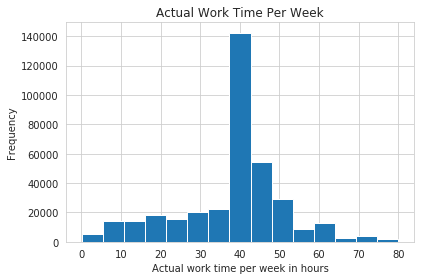

In [15]:
fig, ax = plt.subplots()

pgen.hist("pgtatzeit", bins=15, ax=ax)
plt.title("Actual Work Time Per Week")
plt.xlabel("Actual work time per week in hours")
plt.ylabel("Frequency")
plt.tight_layout()

# Write plot to disk as .png
# fig.savefig('pgtatzeit.png')

<a id="describe-pgtatzeit"></a>
### Describe: Actual Work Time Per Week
Calculate summary statistics of one column in the dataframe.

In [16]:
pgen["pgtatzeit"].describe()

count    366282.000000
mean         38.033905
std          13.102446
min           0.100000
25%          35.000000
50%          40.000000
75%          45.000000
max          80.000000
Name: pgtatzeit, dtype: float64

<a id="describe-pgtatzeit-syear"></a>
### Describe: Actual Work Time Per Week grouped by Survey Year

Calculate summary statistics of one column in the dataframe grouped by another column.

In [17]:
pgen.groupby("syear")["pgtatzeit"].describe()

,count,mean,std,min,25%,50%,75%,max
syear,,,,,,,,
1984,6557.0,39.947231,11.896158,1.0,40.000000,40.0,44.0,80.0
1985,6005.0,39.559200,12.489210,1.0,40.000000,40.0,45.0,80.0
1986,5818.0,39.862667,11.961640,1.0,39.000000,40.0,45.0,80.0
1987,5907.0,39.604877,11.480971,1.0,39.000000,40.0,44.0,80.0
1988,5612.0,38.888630,12.154338,1.0,38.000000,40.0,44.0,80.0
1989,5521.0,39.702408,11.167662,1.0,38.000000,40.0,44.0,80.0
1990,8607.0,41.332378,11.091295,0.2,38.000000,40.0,48.0,80.0
1991,8039.0,39.533417,11.240531,0.2,37.500000,40.0,44.0,80.0
1992,7650.0,39.936325,10.844688,0.6,37.500000,40.0,45.0,80.0


<a id="merge-datasets"></a>
## Merge Datasets

### Merge two datasets based on shared columns

Two datasets can be merged on columns, that exist in both datasets. We will merge `ppathl` (Individual Tracking File) and `pgen` (Generated Individual Data) on `pid` (Never Changing Person ID), `syear` (Survey Year) and `hid` (ID Household), which exist in both datasets.

see: 
- <https://paneldata.org/soep-core/data/ppathl/pid>
- <https://paneldata.org/soep-core/data/ppathl/syear>
- <https://paneldata.org/soep-core/data/ppathl/hid>
- <https://paneldata.org/soep-core/data/pgen/pid>
- <https://paneldata.org/soep-core/data/pgen/syear>
- <https://paneldata.org/soep-core/data/pgen/hid>

In [18]:
merge_on = ["pid", "syear", "hid"]
ppathl_pgen = pd.merge(ppathl, pgen, on=merge_on)
# dimensions of merged dataset
ppathl_pgen.shape

(656960, 129)

### Set values to NaN if condition applies
Set the negative values for `sex` to NaN.

In [19]:
# set to NaN
ppathl_pgen.loc[ppathl_pgen["sex"] < 0, "sex"] = np.nan

In [20]:
ppathl_pgen.columns

Index(['pid', 'syear', 'cid_x', 'sex', 'gebjahr', 'eintritt', 'erstbefr',
       'austritt', 'psample', 'letztbef',
       ...
       'pgimpsnd2', 'pgsndtyp3', 'pgsndjob2', 'pgsndjob3', 'pgimpsnd1',
       'pgsndjob1', 'pgmonth', 'pgpiyear', 'pgmode', 'inputdataset'],
      dtype='object', length=129)

<a id="boxplot-pgtatzeit-sex"></a>
### Boxplot: "Actual Work Time Per Week" and "Gender"

The boxplot shows the distibrution of Actual Work Time Per Week based on gender.

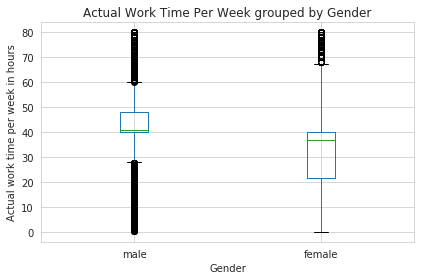

In [21]:
ppathl_pgen.boxplot(
    column="pgtatzeit",
    by="sex"
)
plt.title("Actual Work Time Per Week grouped by Gender")
plt.xlabel("Gender")
plt.ylabel("Actual work time per week in hours")
plt.suptitle("")
plt.xticks([1, 2], ['male', 'female'])
plt.tight_layout()

<a id="boxplot-pgtatzeit-syear"></a>
### Boxplot: "Actual Work Time Per Week" and "Survey Year"

The boxplot shows the distibrution of Actual Work Time Per Week based on Survey Year.

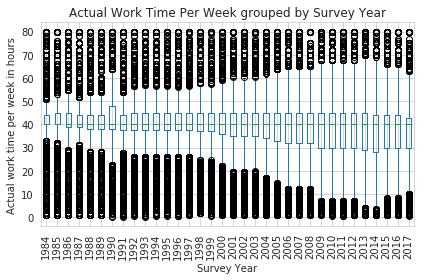

In [22]:
ppathl_pgen.boxplot(
    column="pgtatzeit",
    by="syear"
)
plt.title("Actual Work Time Per Week grouped by Survey Year")
plt.xlabel("Survey Year")
plt.ylabel("Actual work time per week in hours")
plt.suptitle("")
plt.xticks(rotation=90)
plt.tight_layout()

<a id="boxplot-pgtatzeit-syear"></a>
### Boxplot: "Actual Work Time Per Week" and "Survey Year" grouped by "Gender"

The boxplot shows the distibrution of Actual Work Time Per Week based on Survey Year grouped by "Gender".

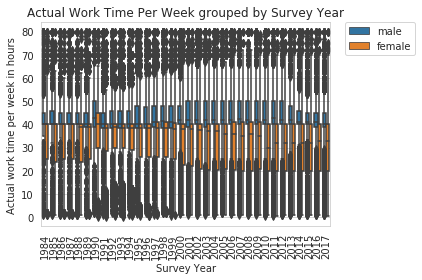

In [23]:
fig, ax = plt.subplots()
ax = sns.boxplot(
    x="syear",
    y="pgtatzeit", 
    hue="sex",
    data=ppathl_pgen
)
plt.title("Actual Work Time Per Week grouped by Survey Year")
plt.xlabel("Survey Year")
plt.ylabel("Actual work time per week in hours")

handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['male', 'female'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

### Correlation between two columns
Calculate the correlation between the variables `pgtatzeit` and `sex`.

In [24]:
ppathl_pgen[["pgtatzeit", "sex"]].corr()

,pgtatzeit,sex
pgtatzeit,1.000000,-0.404648
sex,-0.404648,1.000000


<a id="dataset-hgen"></a>
[Return to top](#top)
## Dataset: `hgen.dta` (Generated Household Data)

From <https://paneldata.org/soep-core/data/hgen>:

> Contains household-level generated data to ensure complete and consitent information over time. It is keyed on HID (Household ID) and SYEAR (Survey Year), see http://www.diw.de/documents/dokumentenarchiv/17/diw_01.c.432036.de/diw_ssp0151_hgen.pdf.

In [25]:
! ls -lh $DATASETS_DIRECTORY/hgen.dta

-rwxr-xr-x 1 afuetterer afuetterer 39M Mär  6 12:36 data/hgen.dta


In [26]:
filename = DATASETS_DIRECTORY / "hgen.dta"
hgen = pd.read_stata(filename, convert_categoricals=False)
hgen.shape

(356864, 68)

In [27]:
hgen.columns

Index(['hid', 'cid', 'syear', 'iyear', 'hgacquis', 'hgcnstyrmax',
       'hgcnstyrmin', 'hgcondit', 'hgelectr', 'hgelectrinfo', 'hgeqpair',
       'hgeqpalm', 'hgeqpbas', 'hgeqpfhea', 'hgeqpgar', 'hgeqphea',
       'hgeqpinsul', 'hgeqpiwc', 'hgeqpkit', 'hgeqplif', 'hgeqpmglass',
       'hgeqpnobar', 'hgeqpnrj', 'hgeqppark', 'hgeqpshw', 'hgeqpsol',
       'hgeqptel', 'hgeqpter', 'hgeqpwat', 'hgf2rent', 'hgfelectr', 'hgfheat',
       'hgfhinc', 'hgfrent', 'hgfroom', 'hgfsize', 'hgutil', 'hgutilinfo',
       'hgfutil', 'hggas', 'hggasinfo', 'hgheat', 'hgheatinfo', 'hghinc',
       'hghmode', 'hghmonth', 'hgi1hinc', 'hgi2hinc', 'hgi3hinc', 'hgi4hinc',
       'hgi5hinc', 'hgmoveyr', 'hgnorent', 'hgnuts1', 'hgosubs', 'hgowner',
       'hgreduc', 'hgrent', 'hgrentinfo', 'hgreval', 'hgroom', 'hgrsubs',
       'hgseval', 'hgsize', 'hgsubsid', 'hgtyp1hh', 'hgtyp2hh',
       'inputdataset'],
      dtype='object')

### Merge two datasets based on shared columns

We will merge the result of the last merge `ppathl_pgen` and `hgen` (Generated Individual Data) on `hid` (ID Household) and `syear` (Survey Year), which exist in both datasets.

In [28]:
merge_on = ["hid", "syear"]
ppathl_pgen_hgen = pd.merge(ppathl_pgen, hgen, on=merge_on)
# dimensions of merged dataset
ppathl_pgen_hgen.shape

(656960, 195)

<a id="variable-hgtyp1hh"></a>
### Variable: `hgtyp1hh` (Household Typology, One Digit)

see: <https://paneldata.org/soep-core/data/hgen/hgtyp1hh>

Value labels:

- 	[1] 1-Pers.-HH
-	[2] Couple Without Children
-	[3] Single Parent
-	[4] Couple With Children LE 16
-	[5] Couple With Children GT 16
-	[6] Couple With Children LE And GT 16
-	[7] Multiple Generation-HH
-	[8] Other Combination
-	[9] No Answer

In [29]:
hgtyp1hh_labels = {
    1: "1-Pers.-HH",
    2: "Couple Without Children",
    3: "Single Parent",
    4: "Couple With Children LE 16",
    5: "Couple With Children GT 16",
    6: "Couple With Children LE And GT 16",
    7: "Multiple Generation-HH",
    8: "Other Combination",
    9: "Answer"
}

In [30]:
hgtyp1hh_counts = ppathl_pgen_hgen.groupby("hgtyp1hh")["pid"].count()
hgtyp1hh_counts.rename(hgtyp1hh_labels, inplace=True)
hgtyp1hh_counts

hgtyp1hh
1-Pers.-HH                            85024
Couple Without Children              189577
Single Parent                         43756
Couple With Children LE 16           151164
Couple With Children GT 16           103382
Couple With Children LE And GT 16     57845
Multiple Generation-HH                14349
Other Combination                     11863
Name: pid, dtype: int64

### Create a new variable: `kindhh`

If `hgtyp1hh` (Household Typology, One Digit) is 1, 2 or 3 the housegold has no children. We create a new variable `kindhh` that is 0 if `hgtyp1hh` is 3 or less and 1 otherwise.

Value labels:

- 	[0] Household has no children
-	[1] Household has at least one child

In [31]:
ppathl_pgen_hgen['kindhh'] = np.where(ppathl_pgen_hgen['hgtyp1hh'] <= 3, 0, 1)

### Modify existing variable `sex`

If `sex` (Gender) is 1 or 2 for "male" or "female". To train a statistical model that needs 0 or 1 as values, we substact the column by 1.

In [32]:
ppathl_pgen_hgen["sex"] = ppathl_pgen_hgen["sex"].astype(np.int64)
ppathl_pgen_hgen["sex"] = ppathl_pgen_hgen["sex"] - 1

<a id="crosstab-hgtyp1hh-kindhh"></a>
### Crosstable between two columns: hgtyp1hh and kindhh

The crosstable shows that the new variable `kindhh` is 0 for households without children and 1 otherwise.

In [33]:
crosstab = pd.crosstab(ppathl_pgen_hgen["hgtyp1hh"], ppathl_pgen_hgen["kindhh"], margins=True)
crosstab.index = list(hgtyp1hh_labels.values())[:8] + ["All"]
crosstab

kindhh,0,1,All
1-Pers.-HH,85024,0,85024
Couple Without Children,189577,0,189577
Single Parent,43756,0,43756
Couple With Children LE 16,0,151164,151164
Couple With Children GT 16,0,103382,103382
Couple With Children LE And GT 16,0,57845,57845
Multiple Generation-HH,0,14349,14349
Other Combination,0,11863,11863
All,318357,338603,656960


### Prepare data for statistical modelling

To estimate model parameters for a Pooled OLS we need to prepare the data. We select only the columns of the merged datasets that we want to take into consideration.

In [34]:
data = ppathl_pgen_hgen[["pid", "syear", "pgtatzeit", "sex", "kindhh"]]

Then we set the index for a row to be the combination of `pid` and `syear`.

In [35]:
data = data.set_index(["pid", "syear"])

<a id="pooled-ols-1"></a>
## Pooled coefficient estimator for panel data

see: <https://bashtage.github.io/linearmodels/doc/panel/models.html#linearmodels.panel.model.PooledOLS>

The PooledOLS is used to analyze if there is a connection between `pgtatzeit` and `sex`.

In [36]:
model = PooledOLS.from_formula(
    'pgtatzeit ~ sex + 1',
    data=data
)
model.fit()

/home/afuetterer/.local/share/virtualenvs/soep-notebooks-jfsdctRl/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,pgtatzeit,R-squared:,0.1637
Estimator:,PooledOLS,R-squared (Between):,0.1666
No. Observations:,365918,R-squared (Within):,0.0000
Date:,"Wed, May 08 2019",R-squared (Overall):,0.1637
Time:,15:31:09,Log-likelihood,-1.428e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,7.165e+04
Entities:,61817,P-value,0.0000
Avg Obs:,5.9194,Distribution:,"F(1,365916)"
Min Obs:,1.0000,,
Max Obs:,34.000,F-statistic (robust):,7.165e+04


**Conclusion**:

On average the gender variable is responsible for a difference of 10 hours, i.e. on average women work 10 hours less than men.

The PooledOLS is used to analyze if there is a connection between `pgtatzeit` and `sex` and `kindhh`.

In [37]:
model = PooledOLS.from_formula(
    'pgtatzeit ~ sex + kindhh + 1',
    data=data
)
model.fit()

Dep. Variable:,pgtatzeit,R-squared:,0.1688
Estimator:,PooledOLS,R-squared (Between):,0.1705
No. Observations:,365918,R-squared (Within):,0.0033
Date:,"Wed, May 08 2019",R-squared (Overall):,0.1688
Time:,15:31:10,Log-likelihood,-1.427e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.717e+04
Entities:,61817,P-value,0.0000
Avg Obs:,5.9194,Distribution:,"F(2,365915)"
Min Obs:,1.0000,,
Max Obs:,34.000,F-statistic (robust):,3.717e+04


**Conclusion**:

On average the gender variable `sex` is responsible for a difference of 10 hours, i.e. on average women work 10 hours less than men.
In addition the variable `kindhh` is responsible for a diffrence of 1,9 hours.

<a id="version-hardware-info"></a>
[Return to top](#top)
## Version and Hardware Information

In [38]:
%load_ext watermark
%watermark -v -m -p ipywidgets,matplotlib,numpy,pandas,linearmodels

CPython 3.7.3
IPython 7.5.0

ipywidgets 7.4.2
matplotlib 3.0.3
numpy 1.16.3
pandas 0.24.2
linearmodels 4.12

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-48-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
